In [1]:
import numpy as np
import GPy
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 無情報事前分布のプロット

In [2]:
# 事前分布の平均
def mean_function(x):
    return np.zeros_like(x)

# 事前分布の共分散行列
def covariance_function(x1, x2, s):
    return np.exp(-(x1 - x2) ** 2 / s ** 2)

def multi_sampling(x, m, L, seed=0):
    # 標準正規分布からx.size点サンプリング
    z = np.random.normal(
        loc   = 0,      # 平均
        scale = 1,      # 標準偏差
        size  = len(x),# 出力配列のサイズ(タプルも可)
    )
    return m + np.dot(L, z) # サンプルをシフトする

In [3]:
x = np.linspace(-10, 10, 80)

x1, x2 = np.meshgrid(x, x)

sigma = 1.0

m = mean_function(x)
gram_matrix = covariance_function(x1, x2, sigma)

# コレスキー分解
L = np.linalg.cholesky(gram_matrix)


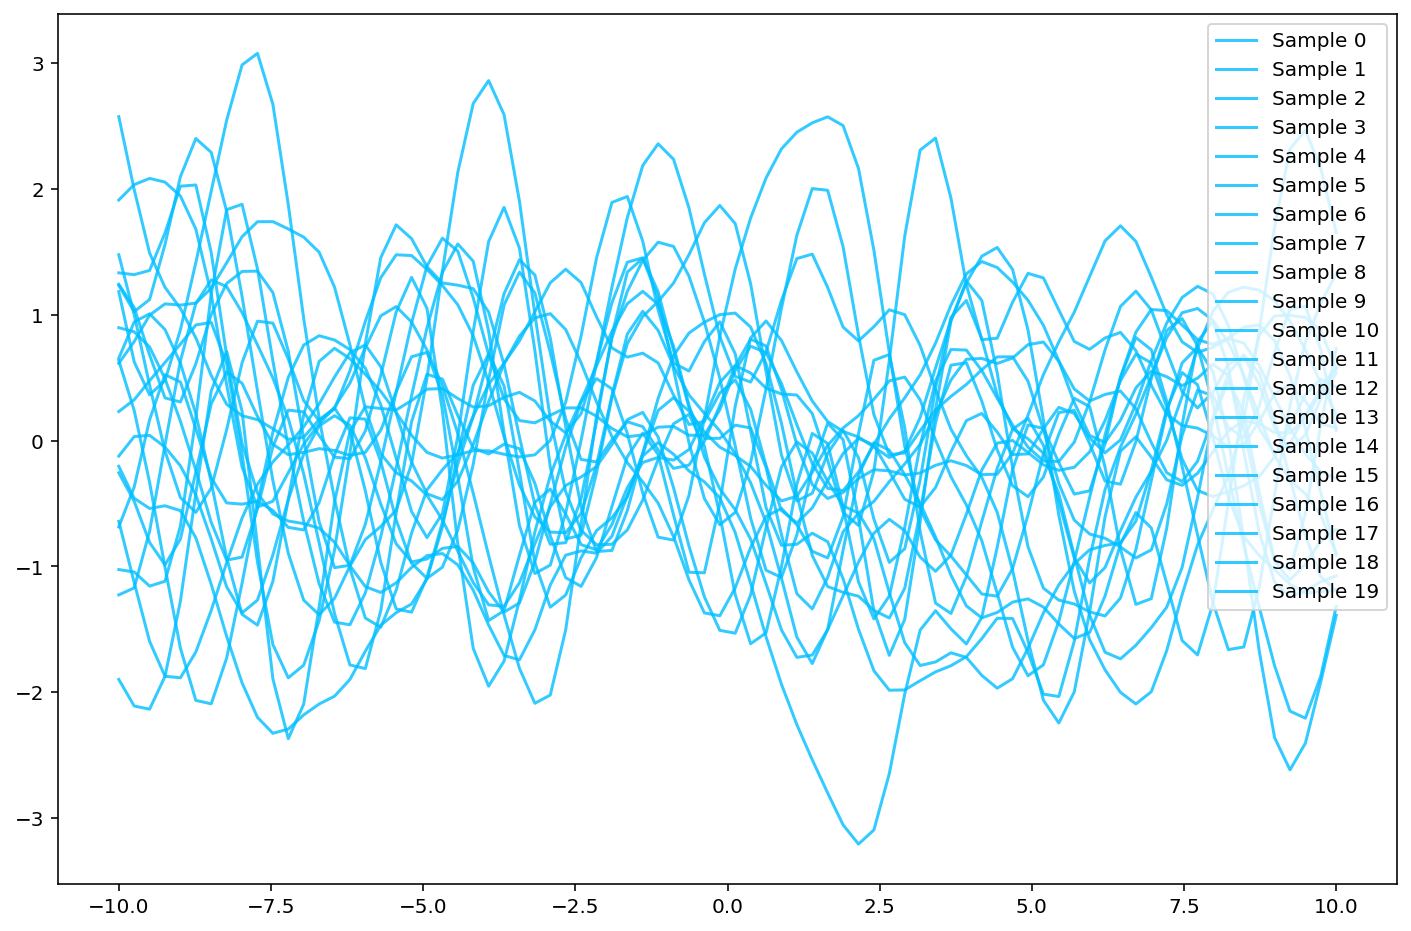

In [4]:
plt.figure(figsize=(12, 8), facecolor='w')

# 関数を20個サンプリングしつつプロット
for k in range(20):
    y_sample = multi_sampling(x, m, L, seed=k)
    
    # y_sample = np.random.multivariate_normal(m, gram_matrix) 
    # →numpyの関数. 多変量ガウス分布からのサンプリングが可能. ただし、行列>0でなくてもいいよう, コレスキー分解ではなく, SVDで実装されている.
    
    plt.plot(x, y_sample, label=f'Sample {k}', color='deepskyblue', alpha=0.8)

plt.legend(loc='upper right')

## GPで訓練

In [5]:
# 訓練点
X = np.array([[-7.1],[-3.2], [-0.1], [3.5], [6.6]])
Y = np.array([[0.1],[-0.2], [0.5], [1.5], [0.6]])

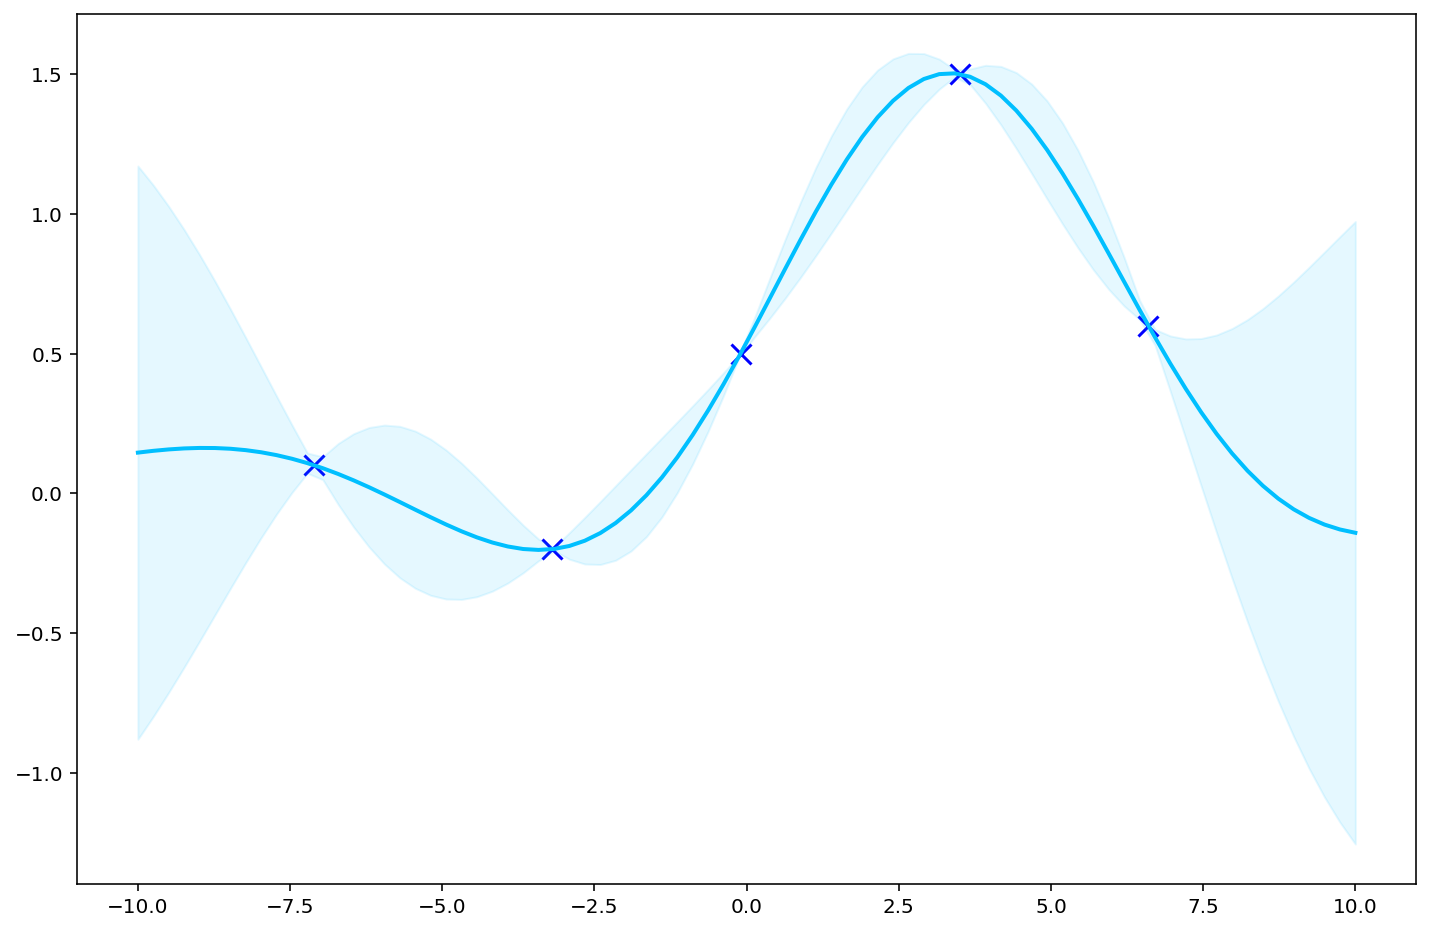

In [6]:
kernel = GPy.kern.RBF(1)

model = GPy.models.GPRegression(X, Y, kernel=kernel)
model.optimize()

# model.plot()
# → GPyのメソッド. このコマンド一つで同様のプロットが可能.

## prediction
x_axis = np.linspace(-10, 10, 80).reshape(-1,1)

# 各点の事後分布の平均と共分散を取得(i.e. p(x_i ; (X,Y)))
f_mean, f_var = model.predict(x_axis) # 同時分布ではなく、各点の事後平均(in R^n) と事後共分散(in R^n)を出力

# 2σ区間の算出
f_upper, f_lower = f_mean + 2*np.sqrt(f_var), f_mean - 2.*np.sqrt(f_var)

## plot
plt.figure(figsize=(12, 8), facecolor='w')

# データ点のプロット
plt.scatter(X, Y, color='blue', marker='x', s=100) 
# 平均値の描画
plt.plot(x_axis, f_mean, color='deepskyblue', lw=2)
# 2σ区間の描画
plt.fill_between(x_axis[:,0], f_lower[:,0], f_upper[:,0], color='deepskyblue', alpha=.1)

### 同時分布のサンプリング
#### GPyのメソッドを用いる.

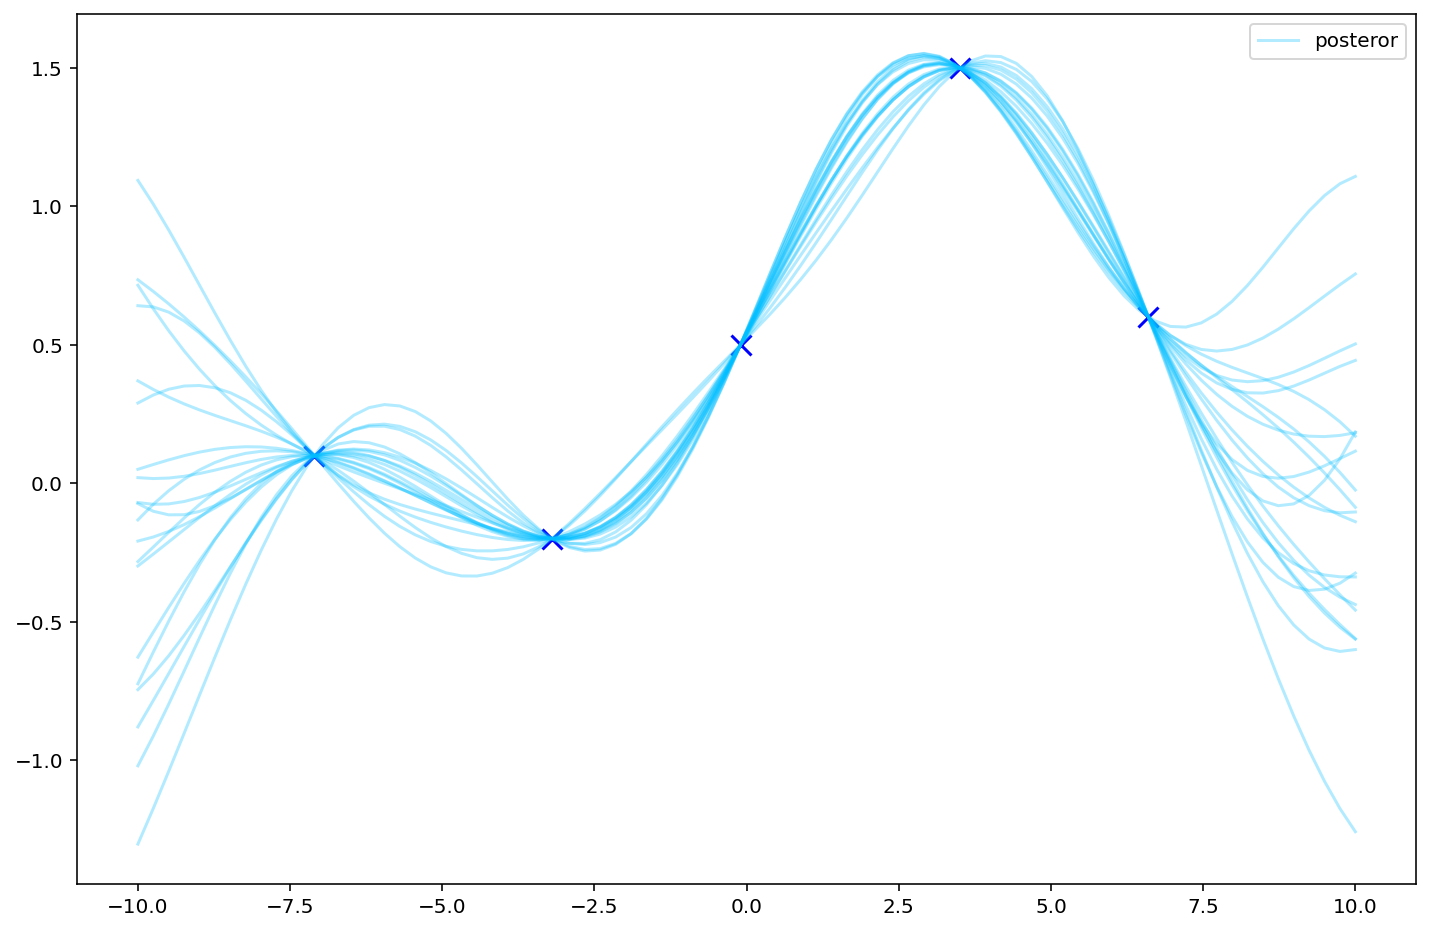

In [7]:
# 同時事後分布からのサンプリング（PRML2章の公式から、同時事後分布
posterior = model.posterior_samples_f(x_axis, size=20)

plt.figure(figsize=(12, 8), facecolor='w')
for i, pos in enumerate(posterior.T):
    label = None
    if i == 0:
        label = "posteror"        
    plt.plot(x_axis, pos.reshape(-1,1), color="deepskyblue", alpha=0.3,  label=label)
plt.scatter(X, Y, color='blue', marker='x', s=100) 
plt.legend()

#### 明示的に行う.

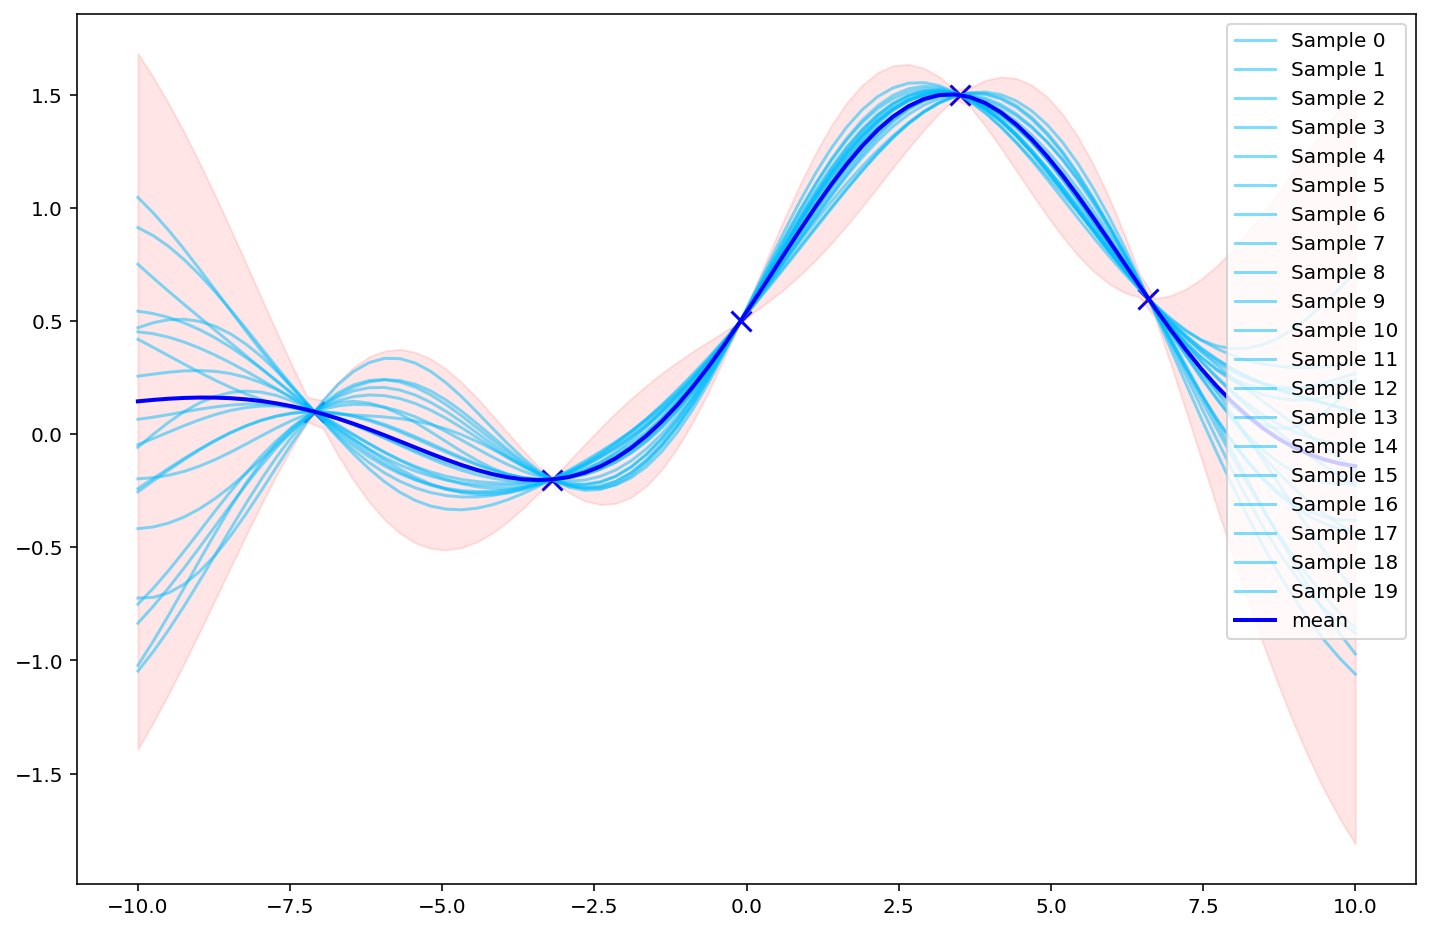

In [24]:
# 共分散関数のコレスキー分解
predict_kwargs = {}
predict_kwargs["full_cov"] = True

x_axis = np.linspace(-10, 10, 80).reshape(-1,1)

# 事後同時分布から、事後共分散行列が得られる。
f_mean, f_cov = model._raw_predict(x_axis,  **predict_kwargs) 

# コレスキー分解
# L = np.linalg.cholesky(f_cov) 
# →　x_axisに対して、何故か正定値でなくなる...（数値誤差？）　

plt.figure(figsize=(12, 8), facecolor='w')

# 関数を10個サンプリングしつつプロット
for k in range(20):
#     y_sample = multi_sampling(x_axis.reshape(-1), f_mean.reshape(-1), L)
    y_sample = np.random.multivariate_normal(f_mean.reshape(-1), f_cov) # 正定値なくてもいいように、特異値分解を使っている.
    plt.plot(x_axis, y_sample, label=f'Sample {k}', color='deepskyblue', alpha=0.5)

f_upper, f_lower = f_mean + 3*np.sqrt(f_var), f_mean - 3.*np.sqrt(f_var)

plt.scatter(X, Y, color='blue', marker='x', s=100) 
plt.fill_between(x_axis[:,0], f_lower[:,0], f_upper[:,0], color='red', alpha=.1)
plt.plot(x_axis, f_mean, color='blue', lw=2, label='mean')
plt.legend(loc='upper right')

### 参考
- https://statmodeling.hatenablog.com/entry/how-to-use-GPy
- https://eqseqs.hatenablog.com/entry/2018/09/24/181322

ガウス分布のシフト公式
- https://research.miidas.jp/2019/09/%E5%A4%9A%E5%A4%89%E9%87%8F%E3%82%AC%E3%82%A6%E3%82%B9%E3%81%AE%E6%A8%99%E6%BA%96%E5%8C%96%E3%81%A8%E7%89%B9%E7%95%B0%E5%80%A4%E5%88%86%E8%A7%A3%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6/

公式ドキュメント
- https://gpy.readthedocs.io/en/deploy/_modules/GPy/util/normalizer.html#Standardize
- https://gpy.readthedocs.io/en/deploy/_modules/GPy/core/gp.html#GP.posterior_samples_f